In [ ]:

import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

# from src.utils.hf_utils import download_weights
# from src.utils.vit_config import inizialize_model
from src.data.dataset import PatchFromH5Dataset
from src.rl.train import CustomTrainer, TrainingArguments

from src.rl.modelling import ViT_UCB_Pruning


In [ ]:
NUM_STEPS = 100000 
LEARNING_RATE = 0.1 
WEIGHT_DECAY = 0.01 
DECAY_TYPE = "cosine"
WARMUP_STEPS = 500
IMG_SIZE = 224
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 8
NUM_CLASSES = 2
GRADIENT_ACCUMULATION_STEPS = 4

In [ ]:
# HF_WEIGHTS_PATH = "/equilibrium/datasets/TCGA-histological-data/vit_weights_cache"
# weights_path = download_weights(HF_WEIGHTS_PATH)

# timm_pretrained_state_dict = torch.load(weights_path, map_location="cpu")

In [ ]:
model = ViT_UCB_Pruning(model_name="hf-hub:MahmoodLab/uni", pretrained=True, n_classes=2)

In [ ]:
dataset = PatchFromH5Dataset(
    h5_dir='/equilibrium/datasets/TCGA-histological-data/hest_patches_only/patches',
    transform=transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),])
)

In [ ]:
labels = [dataset.label_to_idx[dataset.sample_to_label[file.replace('.h5','')]]
          for (file, _) in dataset.data_index]

indices = list(range(len(dataset)))

# Split stratificato
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# Crea i Subset
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=16, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=16, drop_last=True)

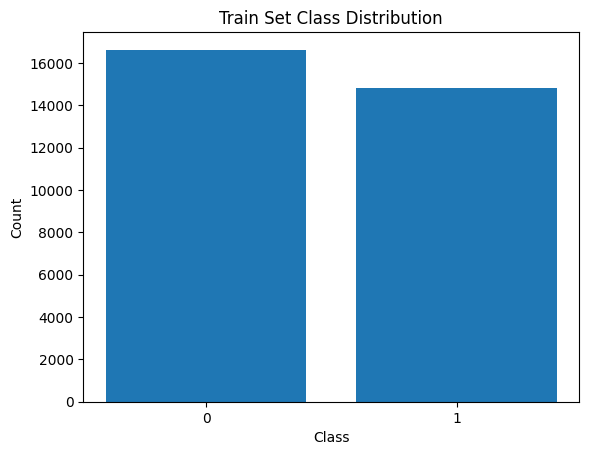

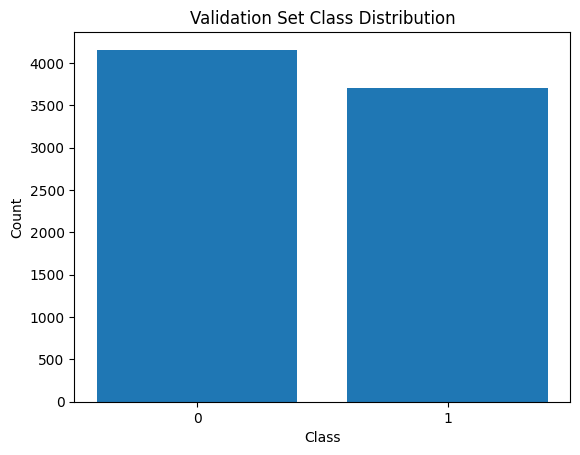

In [7]:
# Plot distribution of classes in train and val sets
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(unique)
    plt.show()
plot_class_distribution([labels[i] for i in train_idx], "Train Set Class Distribution")
plot_class_distribution([labels[i] for i in val_idx], "Validation Set Class Distribution")

In [8]:
loss_function = torch.nn.CrossEntropyLoss()

In [9]:
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=WEIGHT_DECAY,
)

In [10]:
if DECAY_TYPE == "cosine":
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=NUM_STEPS
    )
else: # DECAY_TYPE == "linear"
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=NUM_STEPS
    )

In [11]:
args = TrainingArguments(
        output_dir="./results",
        run_name="ViT-L-UCB-Pruning-run1",
        learning_rate=0.01,
        train_batch_size=8,
        eval_batch_size=8,
        max_steps=20000,
        warmup_steps=500,
        eval_steps=2000,
        save_steps=3000,
        logging_steps=25,
        fp16=False,
        report_to="wandb", # Change to "none" if you don't use Weights & Biases
    )

trainer = CustomTrainer(
        model=model,
        args=args,
        train_dataloader=train_loader,
        eval_dataloader=val_loader,
    )

/home/vcivale/UNI_UCB2/src/rl/train.py:88: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=self.args.fp16)
wandb: Currently logged in as: vincenzo-civale (vincenzo-civale-universi-degli-studi-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
trainer.train()

07/18/2025 17:49:49 - INFO - src.rl.train - ***** Running training *****
07/18/2025 17:49:49 - INFO - src.rl.train -   Num optimization steps = 20000
07/18/2025 17:49:49 - INFO - src.rl.train -   Instantaneous batch size per device = 8
Epoch 1:   0%|          | 0/1966 [00:00<?, ?it/s]/home/vcivale/UNI_UCB2/src/rl/train.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.fp16):
Epoch 1:   1%|          | 24/1966 [00:17<20:59,  1.54it/s, loss=0.6309, lr=4.80e-04] 